# Calculating terrain parameters

> This notebook is [available on GitHub here.](https://github.com/trchudley/pdemtools/blob/main/notebooks/terrain_parameters.ipynb)

`pdemtools` can derive simple geomorphometry such as hillshades, slopes, and curvatures using a one-line function.

First, we must import `pdemtools`, in addition to the in-built `os` library for file management and `matplotlib` to plot our results in this notebook.

In [1]:
import os

import pdemtools as pdt
import matplotlib.pyplot as plt

plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.sans-serif'] = "Arial"

%matplotlib inline

## Load mosiac

We will make use of the pDEMtools' `load.mosaic()` function to download the 32 m resolution ArcticDEM mosaic of Helheim Glacier, as outlined in the 'mosaic' tutorial.

In [2]:
%%time

bounds = (295000, -2585000, 315000, -2567000)

dem = pdt.load.mosaic(
    dataset='arcticdem',  # must be `arcticdem` or `rema`
    resolution=32,        # must be 2, 10, or 32
    bounds=bounds,        # (xmin, ymin, xmax, ymax) or a shapely geometry
    version='v4.1',       # optional: desired version (defaults to most recent)
)

CPU times: user 288 ms, sys: 120 ms, total: 408 ms
Wall time: 8.22 s


In [3]:
if not os.path.exists('example_data'):
    os.mkdir('example_data')

dem.rio.to_raster(os.path.join('example_data', 'helheim_arcticdem_mosaic_32m.tif'), compress='ZSTD', predictor=3, zlevel=1)

In [4]:
bedmachine_fpath = '.../BedMachineGreenland-v5.nc'

geoid = pdt.data.geoid_from_bedmachine(bedmachine_fpath, dem)

dem_geoidcor = dem.pdt.geoid_correct(geoid)

dem_masked = dem_geoidcor.pdt.mask_ocean(near_sealevel_thresh_m=5)

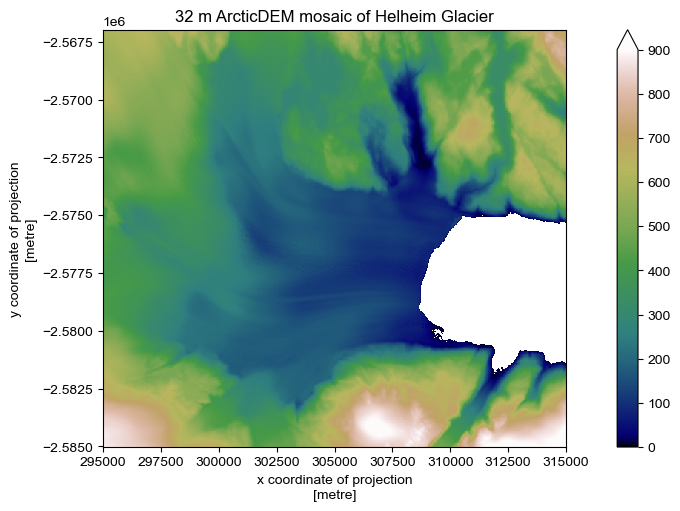

In [5]:
fig, ax = plt.subplots(figsize=(7, 5))

dem_masked.plot.imshow(ax=ax, cmap='gist_earth', vmin=0, vmax=900)

ax.set_aspect('equal')
ax.set_title('32 m ArcticDEM mosaic of Helheim Glacier')
plt.show()

## Postprocessing - Terrain Parameters

pDEMtools introduces a handy [xarray accessor](https://docs.xarray.dev/en/stable/internals/extending-xarray.html) for performing preliminary preprocessing and assessment. These aren't intended to be as full-featured as some other excellent community tools, such as [xdem](https://xdem.readthedocs.io/en/stable/) or [richdem](https://github.com/r-barnes/richdem), but it is hoped that they are _specific_ to the sort of uses that ArcticDEM and REMA users might want (e.g. a focus on ice sheet and cryosphere work), as well as the particular _strengths_ of ArcticDEM and REMA datasets (high-resolution and multitemporal).

Specifically, the `.pdt.terrain()` function allows you to calculate the following list of terrain variables:

In [6]:
variable_list = [
    "slope",
    "aspect",
    "hillshade",
    "plan_curvature",
    "horizontal_curvature",
    "vertical_curvature",
    "horizontal_excess",
    "vertical_excess",
    "mean_curvature",
    "gaussian_curvature",
    "unsphericity_curvature",
    "minimal_curvature",
    "maximal_curvature",
]

The geomorphometric parameters used to calculate these variables ($\frac{\partial z}{\partial x}$, $\frac{\partial z}{\partial y}$, $\frac{\partial^2 z}{\partial x^2}$, $\frac{\partial^2 z}{\partial y^2}$, $\frac{\partial^2 z}{\partial x \partial y}$) are derived following Florinsky (2009), as opposed to more common methods (e.g. Horn, 1981, or Zevenbergen & Thorne, 1987). 

The motivation here is that Florinsky (2009) computes partial derivatives of elevation based on fitting a third-order polynomial, by the least-squares approach, to a 5 $\times$ 5 window, as opposed to the more common 3 $\times$ 3 window. This is more appropriate for high-resolution DEMs: curvature over a 10 m window for the 2 m resolution ArcticDEM/REMA strips will lead to a local deonising effect that limits the impact of noise.

After contructing the list of variabels you would like to calculate, you can request them from the `pdt.terrain()` accessor function. Note there are some bonus settings regarding the hillshade, such as the z factor, using a multidirectional algorithm, or selecting the azimuth/altitude.

In [7]:
terrain = dem_masked.pdt.terrain(variable_list, hillshade_z_factor=2, hillshade_multidirectional=True)

If you would rather calculate these variables using a more traditional method, you can add `method = 'ZevenbergThorne'` to the `.pdt.terrain()` function to calculate following Zevenbergen and Thorne (1987).

The output of the `.pdt.terrain()` function, here the `terrain` variable, is a (rio)xarray DataSet containing all the selected variables, as well as the original DEM:

In [8]:
terrain

<xarray.Dataset> Size: 21MB
Dimensions:                 (x: 626, y: 564)
Coordinates:
  * x                       (x) float64 5kB 2.95e+05 2.95e+05 ... 3.15e+05
  * y                       (y) float64 5kB -2.567e+06 -2.567e+06 ... -2.585e+06
    spatial_ref             int64 8B 0
    mapping                 int64 8B 0
    band                    int64 8B 1
Data variables: (12/14)
    dem                     (y, x) float32 1MB 602.5 603.1 603.1 ... 936.9 937.1
    slope                   (y, x) float32 1MB nan nan nan nan ... nan nan nan
    aspect                  (y, x) float32 1MB nan nan nan nan ... nan nan nan
    hillshade               (y, x) float64 3MB nan nan nan nan ... nan nan nan
    plan_curvature          (y, x) float32 1MB nan nan nan nan ... nan nan nan
    horizontal_curvature    (y, x) float32 1MB nan nan nan nan ... nan nan nan
    ...                      ...
    vertical_excess         (y, x) float32 1MB nan nan nan nan ... nan nan nan
    mean_curvature          (y, x) float32 1MB nan nan nan nan ... nan nan nan
    gaussian_curvature      (y, x) float32 1MB nan nan nan nan ... nan nan nan
    unsphericity_curvature  (y, x) float32 1MB nan nan nan nan ... nan nan nan
    minimal_curvature       (y, x) float32 1MB nan nan nan nan ... nan nan nan
    maximal_curvature       (y, x) float32 1MB nan nan nan nan ... nan nan nan

Note that the tools do not account for edge effects, which instead resolve to `nan` values. 

We can now plot as follows:

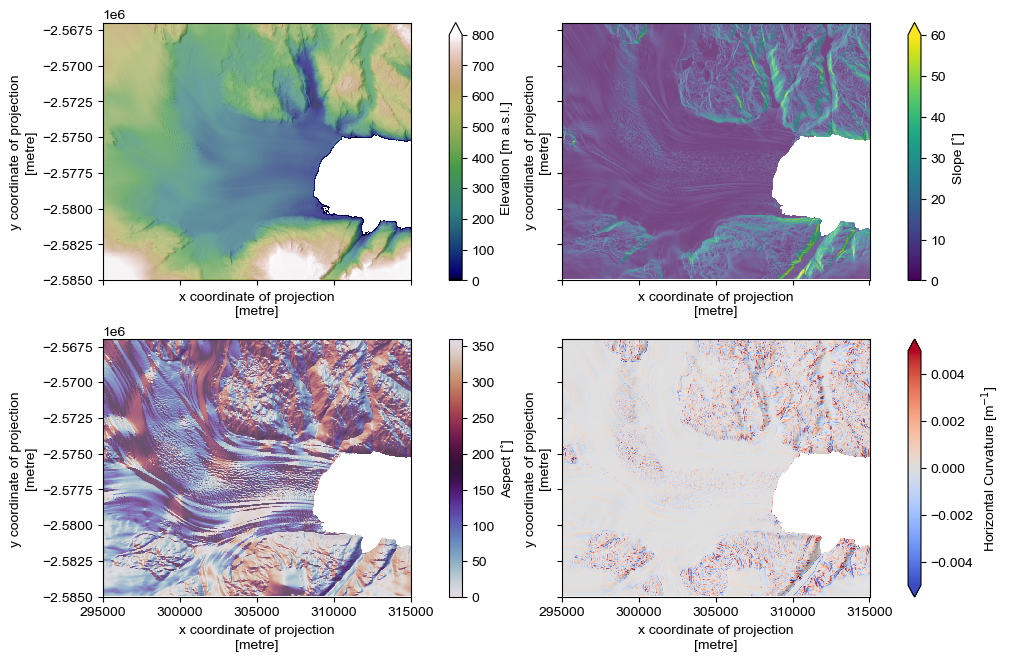

In [9]:
fig, axes = plt.subplots(figsize=(10,6.5), ncols=2, nrows=2, sharex=True, sharey=True)

ax=axes[0,0]
terrain.dem.plot.imshow(cmap='gist_earth', ax=ax, vmin=0, vmax=800, cbar_kwargs={'label': 'Elevation [m a.s.l.]'})

ax=axes[0,1]
terrain.slope.plot.imshow(cmap='viridis', ax=ax, vmin=0, vmax=60, cbar_kwargs={'label': 'Slope [˚]'})

ax=axes[1,0]
terrain.aspect.plot.imshow(cmap='twilight', ax=ax, vmin=0, vmax=360, cbar_kwargs={'label': 'Aspect [˚]'})

ax=axes[1,1]
vrange=0.005
terrain.horizontal_curvature.plot.imshow(cmap='coolwarm', ax=ax, vmin=-vrange, vmax=vrange, cbar_kwargs={'label': 'Horizontal Curvature [m$^{-1}$]'})

for ax in axes.ravel():
    ax.set_aspect('equal')
    terrain.hillshade.plot.imshow(ax=ax, cmap='Greys_r', alpha=.3, add_colorbar=False)
    ax.set_title(None)

plt.savefig(os.path.join('..', 'images', 'example_mosaic_terrain.jpg'), dpi=300)
plt.show()

These terrain parameters provide the foundation for quantiative analysis of elevation fields.